# Clase Autoencoder con capas convolucionales - Imágenes escala de grises.

En el siguiente Notebook vamos a seguir explorando la clase Autoencoder que hicimos en el notebook anterior. En este caso, lo haremos a través de capas convolucionales en lugar de densas. Es mucho más apropiado usar capas convolucionales porque el objetivo del AutoEncoder es, por una parte, realizar una buena extracción de características de las imágenes y, por otro, realizar una buena reconstrrucción de dichas caracterísitcas para poder rescatar una aproximación de la imágen original. Por ese motivo, las convolucionales serán mucho más efectivas.

In [1]:
#Librerías necesarias

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import plotly.express as px
from IPython.display import clear_output
tf.random.set_seed(666)

## Clase AutoEncoder con capas convolucionales.

Modificaremos la clase anterior para que las capas sean convolcionales. Además de contar con las capas Conv2D, también habremos de incorporar las capas de MaxPooling y las Conv2DTranspose que son las que participan en el decoder como movimiento inverso de las Conv2D.

La estructura es:
- Encoder:
    - Conv2D en las que hay que especificar el paddign = "same". 32 filtros en todas las capas de este tipo.
    - MaxPooling de (2,2) para que la imagen vaya reduciendo su tamaño (cada vez a la mitad del anterior).
    - Capa Flatten para preparar la imagen final para el espacio latente.

- Decoder:
    - Conv2DTranspose que hace la operación inversa de las Conv2D. Hay que especificar el strides para duplicar el tamaño de la imagen en cada paso y recuperar el tamaño 28*28.

In [2]:
class AutoEncoder_conv(tf.keras.Model):
    """
    AutoEncoder con capas densas.
    """
    def __init__(self, input_shape):
        """
        Parameters
        ----------
        input_shape: int
            Ancho/largo de las imágenes.
        """
        super(AutoEncoder_conv, self).__init__() #Hereda todos los métodos de tf.keras.Model
        
        #Creamos el modelo secuencial para el encoder
        self.encoder = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3,3), activation = "relu", #Imagen28*28
                                   input_shape=(input_shape,input_shape,1), padding='same'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), #Reducimos la imagen a la mitad 14*14
            tf.keras.layers.Conv2D(16, (3,3), activation = "relu", padding='same'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),#Reducimos la imagen a la mitad 7*7
            tf.keras.layers.Conv2D(8, (3,3), activation = "relu", padding='same')
        ])
        
        self.decoder = tf.keras.models.Sequential([
            tf.keras.layers.Conv2DTranspose(16,(3,3), activation = "relu", 
                                            padding='same', strides = (2,2)),
            tf.keras.layers.Conv2DTranspose(32,(3,3), activation = "relu", 
                                            padding='same', strides = (2,2)),
            tf.keras.layers.Conv2DTranspose(1,(3,3), activation = "relu", 
                                            padding='same', strides = (1,1))
        ])
    
    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded  

Además de la clase base del AutoEncoder, vamos a definir la función para el callback. La función que vamos a definir es:

- La función reconstrucción que nos representará gráficamente la evolución de 10 imágenes a lo largo del entrenamiento.

Y también vamos a definir la función overfit para no tener que copiar código innecesariamente

- La función overfit que nos representará el gráfico de train vs. test. 

In [38]:
def reconstruccion(model, n, data):
    """Función de reconstrucción de imágenes DESPUÉS de cada época"""

    encoded_imgs = model.encoder(data[:n]).numpy()
    decoded_imgs = model.decoder(encoded_imgs).numpy()


    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].reshape(28,28))
        plt.title("Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28,28))
        plt.title("Reconstruida")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
      # plt.show()

In [4]:
def plot_history(history):
    """Función de función del error en train y test después del entrenamiento"""

    plt.figure()
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Test")
    plt.legend()
    # plt.show()

Y ahora definiremos el CallBack con la función para que se ejecute en un momento específico del entrenamiento. La idea de este callback es que ilustre la evolución de las reconstrucciones después de cada época de entrenamiento.

In [39]:
class CallBackReconstruccion(tf.keras.callbacks.Callback):

    def __init__(self, n, data, latent_dim):
        """
        Parameters
        ----------
        n: int
            Número de imágenes a reconstruir.
        data: list
            Listado original de imágenes.
        latent_dim: int
            Dimensión del espacio latente
        """
        self.n = n
        self.data = data
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        reconstruccion(self.model, self.n, self.data)
        plt.suptitle(f"Época {epoch}")

    def on_train_end(self, logs=None):
        if self.latent_dim == 2:
            espacio_latente(model=self.model, latent_dim=self.latent_dim)

## Datos MNIST

Vamos a volver a usar el conjunto de datos MNIST por su sencillez. Será sufieciente para probar nuestra nueva clases con las nuevas capas. En este caso, no visualizaremos las imágenes de muestra.

Cargamos los datos de MNIST

In [6]:
(Xtrain, Ytrain), (Xtest, Ytest) = tf.keras.datasets.mnist.load_data()
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Normalizamos para que en lugar de tener un rango de [0,255] lo tenga de [0,1].

In [7]:
Xtrain = Xtrain / 255
Xtest = Xtest / 255

Es importante expandir las dimensiones de las imágenes para que se explicite el número de canales con las que cuenta la imagen y poder pasarlas por la Conv2D.

In [8]:
Xtrain = np.expand_dims(Xtrain,-1)
Xtest = np.expand_dims(Xtest,-1)

In [13]:
ae_conv = AutoEncoder_conv(input_shape=Xtrain.shape[1])

In [14]:
#Seleccionamos el optimizador y la función de pérdida
ae_conv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), 
                loss="mean_squared_error")

Epoch 1/5
938/938 [==============================] - 11s 11ms/step - loss: 0.0085 - val_loss: 0.0039
Epoch 2/5
938/938 [==============================] - 10s 11ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 3/5
938/938 [==============================] - 11s 11ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 4/5
938/938 [==============================] - 10s 11ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 5/5
938/938 [==============================] - 10s 11ms/step - loss: 0.0025 - val_loss: 0.0023


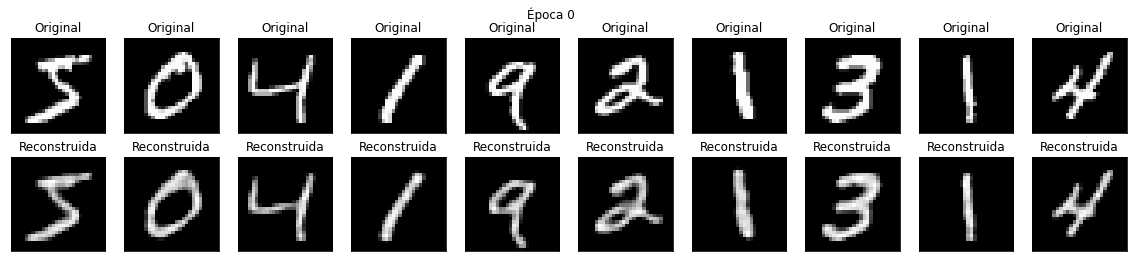

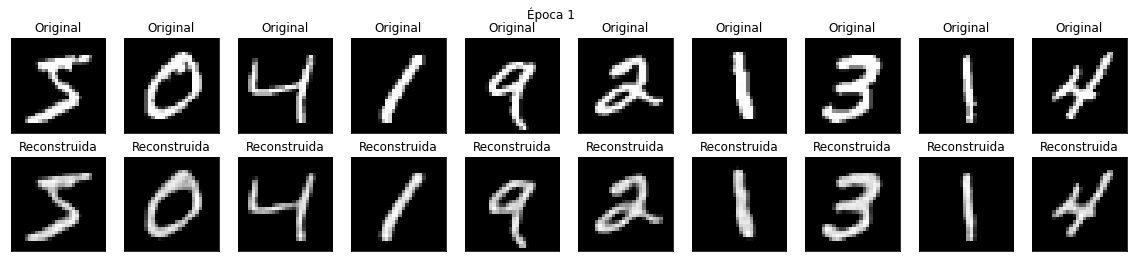

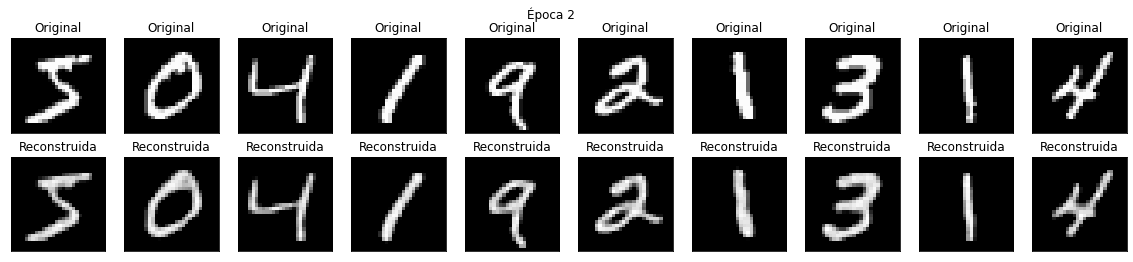

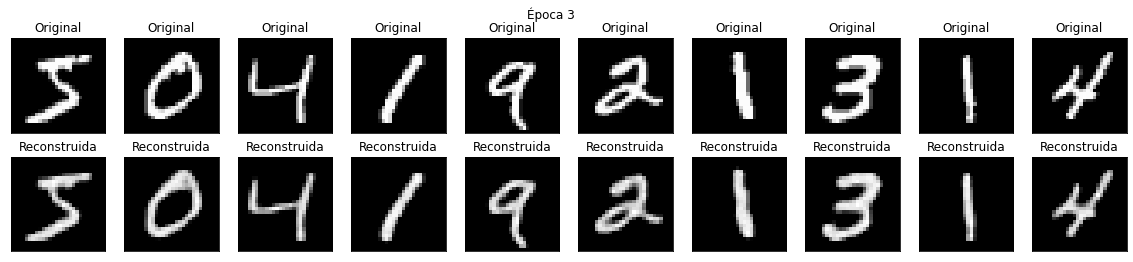

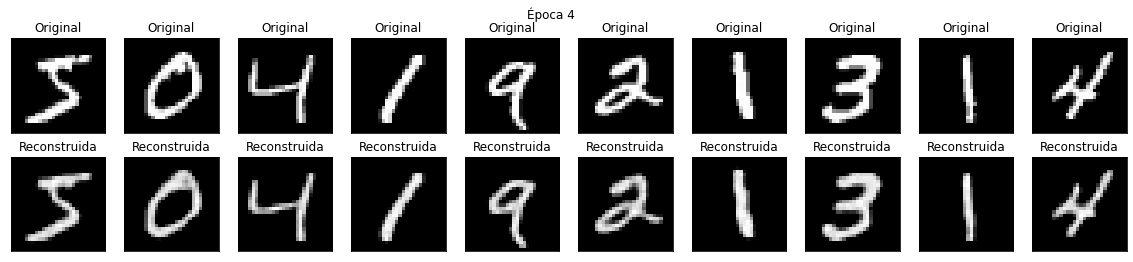

In [15]:
history = ae_conv.fit(Xtrain, Xtrain, 
                           epochs=5,     
                           batch_size=64, 
                           shuffle=True, 
                           validation_data=(Xtest, Xtest),
                           callbacks=[CallBackReconstruccion(n=10, latent_dim=None, data=Xtrain)])


EXPLICA LO DEL OVERFIT

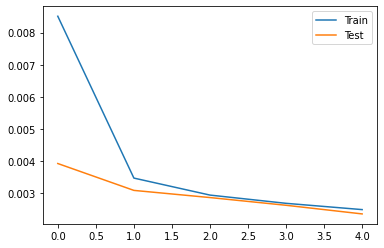

In [16]:
plot_history(history)
plt.show()

## Clase AutoEncoder con capas convolucionales y densas.

Si nos fijamos en como ha evolucionado el modelo anterior, vemos que con solo capas convolucionales el modelo converge en una sola iteración. 

Modificaremos la clase anterior para que junto a las capas convolcionales haya capas densas. El problema de esta estructura es que hay que intercalar muchas capas densas entre el espacio latente y las convolucionales para que la reducción de dimensionalidad se haga gradualmente.

La estructura es:
- Encoder:
    - Conv2D en las que hay que especificar el ```paddign = "same"```. 32 filtros en todas las capas de este tipo.
    - MaxPooling de (2,2) para que la imagen vaya reduciendo su tamaño (cada vez a la mitad del anterior).
    - Capa Flatten para preparar la imagen final para el espacio latente.
    - Capa densa de tamaño 2 que hace representa el espacio latente. 

- Decoder:
    - Capa densa con el mismo tamaño que la Flatten anterior para recuperar el tamaño de la imagen pequeña (en este caso 7*7).
    - Conv2DTranspose que hace la operación inversa de las Conv2D. Hay que especificar el strides para duplicar el tamaño de la imagen en cada paso y recuperar el tamaño 28*28.

In [64]:
class AutoEncoder_conv_d(tf.keras.Model):
    """
    AutoEncoder con capas convolucionales.
    """
    def __init__(self, input_shape, latent_dim):
        """
        Parameters
        ----------
        input_shape: int
            Ancho/largo de las imágenes.
        latent_dim: int
            Dimensión del espacio latente.
        """
        super(AutoEncoder_conv_d, self).__init__() #Hereda todos los métodos de tf.keras.Model
        
        #Creamos el modelo secuencial para el encoder
        self.encoder = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3,3), #Imagen28*28
                                   input_shape=(input_shape,input_shape,1), padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), #Reducimos la imagen a la mitad 14*14
            tf.keras.layers.Conv2D(16, (3,3), padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),#Reducimos la imagen a la mitad 7*7
            # tf.keras.layers.Conv2D(8, (3,3), padding='same'),
            # tf.keras.layers.LeakyReLU(),
            # tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), #Reducimos la imagen a la mitad 3*3
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(64),#Red densa
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(32),#Red densa
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(latent_dim)#Red densa de dos nodos (espacio latente)
        ])
        
        self.decoder = tf.keras.models.Sequential([
            tf.keras.layers.Dense(32, input_shape=(latent_dim,)),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(64),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(128),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(7*7*16),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape((7,7,16)),
            tf.keras.layers.Conv2DTranspose(16,(3,3), padding='same', strides = (2,2)),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(32,(3,3), padding='same', strides = (2,2)),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(1,(3,3), padding='same', strides = (1,1), activation = "sigmoid"),
            # tf.keras.layers.Sigmoid()
        ])
    
    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded    

Para esta ocasión, definiremos nuevos Callbacks. Aprovechando que tenemos capas densas en medio del AE, cuando el espacio latente tenga dimensión 2, haremos una representación gráfica del mismo.

In [34]:
def espacio_latente(model, latent_dim):

    #Codificamos todo los datos de train y los pintamos en función de su etiqueta
    latent = model.encoder(Xtrain[:10000])
    latent_df = pd.DataFrame(latent)
    latent_df["label"] = Ytrain[:10000].astype(str)

    #Representación gráfica
    fig = px.scatter(latent_df, x = 0, y = 1, color = "label",
                     category_orders={"label": ["0","1", "2", "3", "4", "5", "6", "7", "8", "9"]})
    fig.show()

## Mnist

Probaremos la nueva clase con el conjunto de datos Mnist de nuevo.

In [65]:
ae_conv_d = AutoEncoder_conv_d(input_shape=Xtrain.shape[1],latent_dim=2)

In [66]:
#Seleccionamos el optimizador y la función de pérdida
ae_conv_d.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), 
                loss="binary_crossentropy")

Epoch 1/5
938/938 [==============================] - 14s 14ms/step - loss: 0.2191 - val_loss: 0.1936
Epoch 2/5
938/938 [==============================] - 13s 14ms/step - loss: 0.1885 - val_loss: 0.1846
Epoch 3/5
938/938 [==============================] - 13s 14ms/step - loss: 0.1828 - val_loss: 0.1822
Epoch 4/5
938/938 [==============================] - 13s 14ms/step - loss: 0.1802 - val_loss: 0.1795
Epoch 5/5
938/938 [==============================] - 13s 14ms/step - loss: 0.1780 - val_loss: 0.1776


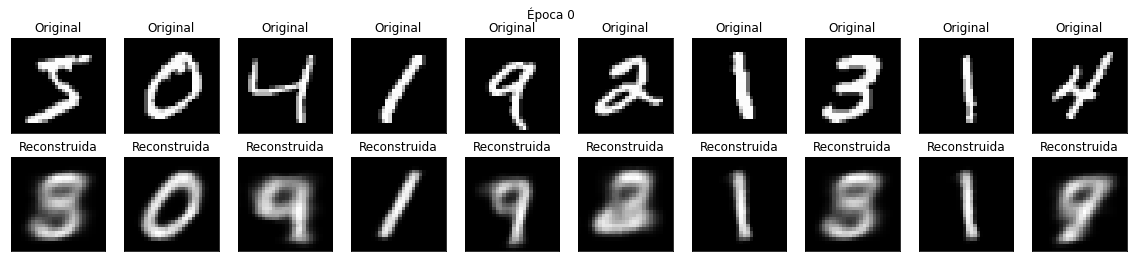

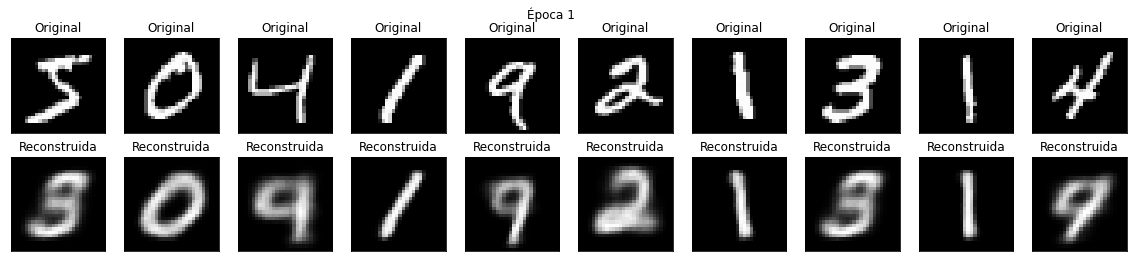

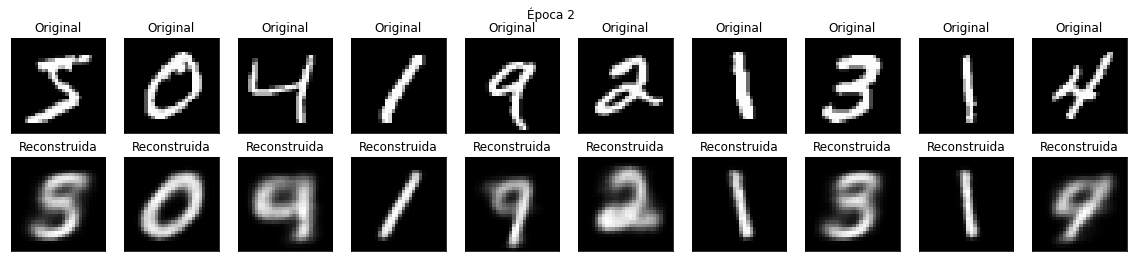

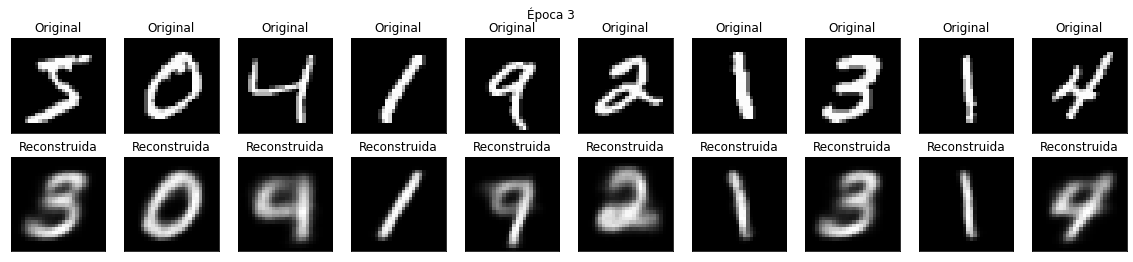

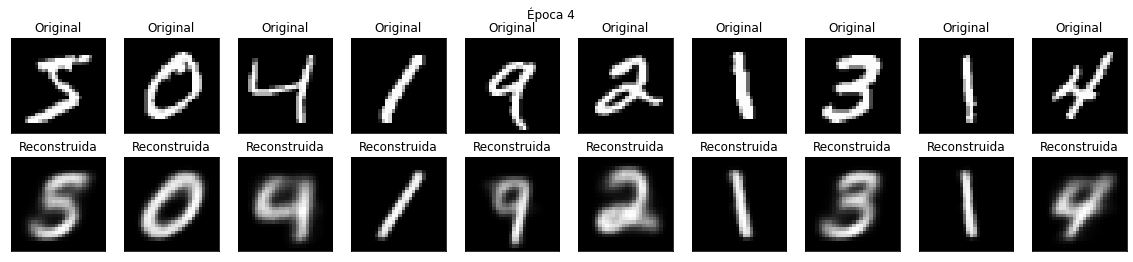

In [67]:
history = ae_conv_d.fit(Xtrain, Xtrain, 
                           epochs=5,     
                           batch_size=64, 
                           shuffle=True, 
                           validation_data=(Xtest, Xtest),
                           callbacks=[CallBackReconstruccion(n=10, latent_dim=2, data=Xtrain)])


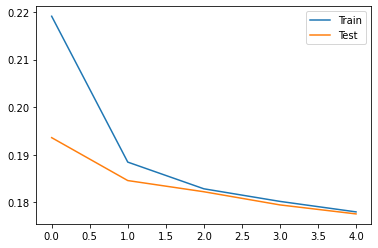

In [68]:
plot_history(history)
plt.show()

## Fashion-Mnist

Por último, haremos la prueba con fashion Mnist

In [26]:
(Xtrain, Ytrain), (Xtest, Ytest) = tf.keras.datasets.fashion_mnist.load_data();
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Normalizamos y añadimos una nueva dimensión a las imagene spara que pasen correctamente por la Conv2D

In [27]:
Xtrain = Xtrain / 255
Xtest = Xtest / 255

In [28]:
Xtrain = np.expand_dims(Xtrain,-1)
Xtest = np.expand_dims(Xtest,-1)

In [30]:
ae_conv = AutoEncoder_conv_d(input_shape=Xtrain.shape[1], latent_dim=2)

In [31]:
#Seleccionamos el optimizador y la función de pérdida
ae_conv.compile(optimizer="adam", loss = "mean_squared_error")

In [32]:
history = ae_conv.fit(Xtrain, Xtrain, 
                           epochs = 20, 
                           batch_size = 64, 
                           shuffle = True, 
                           validation_data=(Xtest, Xtest))

Epoch 1/20
938/938 [==============================] - 16s 16ms/step - loss: 0.0397 - val_loss: 0.0327
Epoch 2/20
938/938 [==============================] - 16s 17ms/step - loss: 0.0315 - val_loss: 0.0302
Epoch 3/20
938/938 [==============================] - 17s 18ms/step - loss: 0.0301 - val_loss: 0.0297
Epoch 4/20
938/938 [==============================] - 16s 17ms/step - loss: 0.0295 - val_loss: 0.0294
Epoch 5/20
938/938 [==============================] - 14s 14ms/step - loss: 0.0289 - val_loss: 0.0286
Epoch 6/20
938/938 [==============================] - 17s 19ms/step - loss: 0.0289 - val_loss: 0.0282
Epoch 7/20
938/938 [==============================] - 18s 19ms/step - loss: 0.0282 - val_loss: 0.0279
Epoch 8/20
938/938 [==============================] - 18s 19ms/step - loss: 0.0279 - val_loss: 0.0281
Epoch 9/20
938/938 [==============================] - 17s 18ms/step - loss: 0.0278 - val_loss: 0.0276
Epoch 10/20
938/938 [==============================] - 14s 15ms/step - loss: 0.027

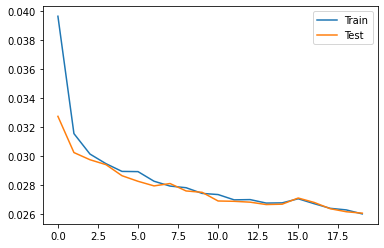

In [33]:
overfit(history)